In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 75 kB 4.8 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627558 sha256=ad2c9f200df9858315507ac0c5cd7fb3d2467468da4ab43ab829fcc76deb1f39
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=5dcb79770a7be65f7c75930294400f2eedcc9bdd92157406173c5d48e94956a9
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


In [8]:
!python main.py image.jpg out.jpg


main.py:71: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

  mod = compiler.SourceModule(open('gaussian_blur.cu').read())
Total processing time:  0.004769466999960059 s


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


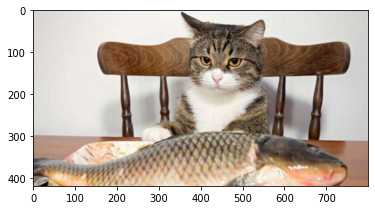

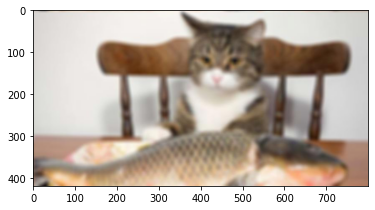

In [19]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy as np
import math
import sys
from PIL import Image


image = Image.open("image.jpg")
input_array = np.array(image)
red_channel = input_array[:, :, 0].copy()
green_channel = input_array[:, :, 1].copy()
blue_channel = input_array[:, :, 2].copy()

mod = SourceModule("""
__global__ void applyFilter(const unsigned char *input, unsigned char *output, const unsigned int width, const unsigned int height, const float *kernel, const unsigned int kernelWidth) {

    const unsigned int col = threadIdx.x + blockIdx.x * blockDim.x;
    const unsigned int row = threadIdx.y + blockIdx.y * blockDim.y;

    if(row < height && col < width) {
        const int half = kernelWidth / 2;
        float blur = 0.0;
        for(int i = -half; i <= half; i++) {
            for(int j = -half; j <= half; j++) {

                const unsigned int y = max(0, min(height - 1, row + i));
                const unsigned int x = max(0, min(width - 1, col + j));

                const float w = kernel[(j + half) + (i + half) * kernelWidth];
                blur += w * input[x + y * width];
            }
        }
        output[col + row * width] = static_cast<unsigned char>(blur);
    }
}
""")

sigma = 5 
kernel_width = int(3 * sigma)
if kernel_width % 2 == 0:
    kernel_width = kernel_width - 1

kernel_matrix = np.empty((kernel_width, kernel_width), np.float32)
kernel_half_width = kernel_width // 2
for i in range(-kernel_half_width, kernel_half_width + 1):
    for j in range(-kernel_half_width, kernel_half_width + 1):
        kernel_matrix[i + kernel_half_width][j + kernel_half_width] = (
                np.exp(-(i ** 2 + j ** 2) / (2 * sigma ** 2))
                / (2 * np.pi * sigma ** 2)
        )
gaussian_kernel = kernel_matrix / kernel_matrix.sum()

height, width = input_array.shape[:2]
dim_block = 32
dim_grid_x = math.ceil(width / dim_block)
dim_grid_y = math.ceil(height / dim_block)

func = mod.get_function("applyFilter")


for channel in (red_channel, green_channel, blue_channel):
    func(
        cuda.In(channel),
        cuda.Out(channel),
        np.uint32(width),
        np.uint32(height),
        cuda.In(gaussian_kernel),
        np.uint32(kernel_width),
        block=(dim_block, dim_block, 1),
        grid=(dim_grid_x, dim_grid_y)
    )



output_array = np.empty_like(input_array)
output_array[:, :, 0] = red_channel
output_array[:, :, 1] = green_channel
output_array[:, :, 2] = blue_channel


Image.fromarray(output_array).save("blur.jpg")

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("image.jpg")
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread("blur.jpg")
imgplot = plt.imshow(img)
plt.show()

